# Importer Libraries et Données

In [1]:
# %reload_ext autoreload
%load_ext autoreload
%autoreload 2

In [12]:
# import libraries
import re
import warnings

# LDA Topic Modeling and word preprocessing
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaMulticore, phrases, Phrases
from gensim.utils import simple_preprocess

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # **important**

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from yellowbrick.features import PCA as yb_PCA

import helper as hp

nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])
# suppress tight layout warnings
warnings.filterwarnings("ignore", message="Tight layout not applied.")
warnings.filterwarnings("ignore", category=RuntimeWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# import dataframe
df =  pd.read_csv('data/df_cat.csv')
df.shape

(1050, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    1050 non-null   object 
 13  product_specifications   1049 non-null   object 
 14  cat                     

In [5]:
# keep useful columns only
df = df[['description', 'brand', 'cat']]
df.head()

,description,brand,cat
0,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing
4,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing


In [6]:
df_copy = df.copy()

# Fonctions d'Outils

In [121]:
def clean_and_tokenize(corpus: str) -> list:
    """
    Clean and tokenize the input corpus

    Parameters
    ----------
    corpus: str
        corpus to be cleaned and tokenized

    Returns
    -------
    list
        a list of tokens

    """
    # replace interrupting punctuation with a full stop
    text = re.sub(r"[.,!?;-]+", ". ", corpus)
    # remove non-interrupting punctuation and numbers
    text = re.sub(r"[0-9(){}[]%#@*^'\"]+", "", text)
    # tokenization
    return nltk.word_tokenize(text)


def process_corpus(df: pd.DataFrame, lem_or_stem: str = "lem") -> pd.Series:
    """
    Clean and tokenize the input corpus.
    Then lemmatize or stemmer the tokens.

    Parameters
    ----------
    df: pd.DataFrame
        a dataframe that contains the corpus and words to be excluded
    lem_or_stem: str, optional (default is 'lem')
        perform lemmatization if equal to 'lem' or
        perform stemming if equal to 'stem'

    Returns
    -------
    pd.Series
        a series contained the processed tokens

    """

    # get English stopwords
    stop_words = set(stopwords.words("english"))
    stop_words.add("flipkart")
    stop_words.add("rockmantra")

    if lem_or_stem == "lem":
        # instantiate Wordnet Lemmatizer
        lemmatizer = WordNetLemmatizer()
        for idx, corpus in enumerate(df.description):
            # clean and tokenize corpus
            tokens = clean_and_tokenize(corpus)
            # lemmatization, uncapitalize and keep only full-stop and
            # letters that have more than 2 alphbets
            df.description[idx] = [
                lemmatizer.lemmatize(token).lower()
                for token in tokens
                if (
                    (token.lower() not in list(stop_words))
                    & (len(token) > 2)
                    & (token != df.brand[idx])
                    & token.isalpha()
                )
                or (token == ".")
            ]
    elif lem_or_stem == "stem":
        # instantiate EnglishStemmer
        stemmer = EnglishStemmer()
        for idx, corpus in enumerate(df.description):
            # clean and tokenize corpus
            tokens = clean_and_tokenize(corpus)
            # stemming, uncapitalize and keep only full-stop and
            # letters that have more than 2 alphbets
            df.description[idx] = [
                stemmer.stem(token).lower()
                for token in tokens
                if (
                    (token.lower() not in list(stop_words))
                    & (len(token) > 2)
                    & (token != df.brand[idx])
                    & token.isalpha()
                )
                or (token == ".")
            ]
    elif lem_or_stem == "lemstem":
        # instantiate Wordnet Lemmatizer and EnglishStemmer
        lemmatizer = WordNetLemmatizer()
        stemmer = EnglishStemmer()
        for idx, corpus in enumerate(df.description):
            # clean and tokenize corpus
            tokens = clean_and_tokenize(corpus)
            # stemming, uncapitalize and keep only full-stop and
            # letters that have more than 2 alphbets
            df.description[idx] = [
                stemmer.stem(lemmatizer.lemmatize(token)).lower()
                for token in tokens
                if (
                    (token.lower() not in list(stop_words))
                    & (len(token) > 2)
                    & (token != df.brand[idx])
                    & token.isalpha()
                )
                or (token == ".")
            ]
    else:
        print(f"{lem_or_stem} is an invalid value.")
        print("Please enter 'lem' for lemmatization or 'stem' for stemming.")

    return df.description


def create_bow(corpus: pd.Series) -> dict:
    """
    Create bag of words from a corpus

    Parameters
    ----------
    corpus: pd.Series
        corpus from which to create a bag of word

    Returns
    -------
    dict
        a bag of words

    """

    # create a set of vocabulories that the corpus has
    vocabs = list(set(corpus.explode()))
    print(f"Total tokens count: {len(vocabs):>21}")
    # create bag of words: count frequency of each word in the corpus
    df_all = pd.DataFrame(corpus.explode().value_counts())
    # filter words that appear just one time in the corpus
    df_1_freq = df_all[df_all.iloc[:, 0] == 1]
    # assign them as unknown words
    unknown = df_1_freq.index.to_list()
    # replace all the unknown words as <UNK>
    for idx, vocab in enumerate(vocabs):
        if vocab in unknown:
            vocabs[idx] = "<UNK>"
    # create a vocabulory dictionary, i.e., bag of words, with unknown words grouped
    vocabs_new = set(vocabs)
    print(f"Tokens count after creating '<UNK>': {len(vocabs_new)}")
    print(
        f"Bag of words size reduced by: {(1-(len(vocabs_new)/len(vocabs)))*100:>12.2f}%"
    )
    return {vocab: idx for idx, vocab in enumerate(sorted(vocabs_new))}


def create_w2v(vocabs: dict, corpus: pd.Series) -> np.ndarray:
    """
    Create Word2Vec from a bag of words and a corpus

    Parameters
    ----------
    vocabs: dict
        a bag of words from which the Word2Vec creation is based
    corpus: pd.Series
        a corpus from which to create Word2Vec

    Returns
    -------
    np.ndarray
        Word vectors

    """

    # initilize variables
    word2vec = []
    vector = np.zeros(len(vocabs))

    for idx, text in enumerate(corpus):
        for word in text:
            # assign known words to vector
            try:
                vector[vocabs[word]] += 1
            # assign unknown words to vector
            except KeyError:
                vector[1] += 1

        word2vec.append(vector / len(text))
    return np.stack(word2vec, axis=0)  # convert list to ndarray


def get_best_topic_per_doc(bow_corpus: list, lda: LdaMulticore) -> list:
    """Get the topic with the highest probability for each document.
    Then save it in the df.

    Parameters
    ----------
    bow_corpus: list
        a bag of words generated by the Gensim librairy
    lda: LdaMulticore
        a Gensim LdaMulticore trained model to be used to generate
        topics prediction for each documents in the corpus

    Returns
    -------
    list
        a list of topics with the highest probability for each document in the corpus
    """
    preds = []
    best_topics = []
    # get topics prediction for each document
    for doc in bow_corpus:
        preds.append(lda.get_document_topics(doc))
    # get the best topic amongs predicted topics for each document
    for idx, pred in enumerate(preds):
        max_prob = 0
        best_topic = None
        for (topic_num, prob) in pred:
            if prob > max_prob:
                max_prob = prob
                best_topic = topic_num
        best_topics.append(best_topic)
    return best_topics

# Nettoyage de Données

In [8]:
pd.set_option('max_colwidth', 200)

In [9]:
df.description[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

## Lemmatization

In [10]:
%%time
df['token_lem'] = process_corpus(df.loc[:, ('description', 'brand')])

CPU times: user 6.11 s, sys: 0 ns, total: 6.11 s
Wall time: 6.12 s


In [31]:
print(*df.token_lem[0])

key features polyester multicolor abstract eyelet door curtain floral curtain . polyester multicolor abstract eyelet door curtain height . pack price . curtain enhances look interior . curtain made high quality polyester fabric . feature eyelet style stitch metal ring . make room environment romantic loving . curtain ant . wrinkle anti shrinkage elegant apparance . give home bright modernistic appeal design . surreal attention sure steal heart . contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening . create special moment joyous beauty given soothing print . bring home elegant curtain softly filter light room get right amount sunlight . specifications polyester multicolor abstract eyelet door curtain height . pack general brand designed door type eyelet model name abstract polyester door curtain set model color multicolor dimensions length box number contents sales package pack sale

## Stemming

In [11]:
%%time
df["token_stem"] = process_corpus(
    df.loc[:, ("description", "brand")], lem_or_stem='stem'
)

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.58 s


In [33]:
print(*df.token_stem[0])

key featur polyest multicolor abstract eyelet door curtain floral curtain . polyest multicolor abstract eyelet door curtain height . pack price . curtain enhanc look interior . curtain made high qualiti polyest fabric . featur eyelet style stitch metal ring . make room environ romant love . curtain ant . wrinkl anti shrinkag eleg appar . give home bright modernist appeal design . surreal attent sure steal heart . contemporari eyelet valanc curtain slide smooth draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even . creat special moment joyous beauti given sooth print . bring home eleg curtain soft filter light room get right amount sunlight . specif polyest multicolor abstract eyelet door curtain height . pack general brand design door type eyelet model name abstract polyest door curtain set model color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest


## Lemmatization & Stemming

In [12]:
%%time
df["token_lem_stem"] = process_corpus(
    df.loc[:, ("description", "brand")], lem_or_stem='lemstem'
)

CPU times: user 4.9 s, sys: 0 ns, total: 4.9 s
Wall time: 4.87 s


In [10]:
print(*df.token_lem_stem[0])

key featur polyest multicolor abstract eyelet door curtain floral curtain . polyest multicolor abstract eyelet door curtain height . pack price . curtain enhanc look interior . curtain made high qualiti polyest fabric . featur eyelet style stitch metal ring . make room environ romant love . curtain ant . wrinkl anti shrinkag eleg appar . give home bright modernist appeal design . surreal attent sure steal heart . contemporari eyelet valanc curtain slide smooth draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even . creat special moment joyous beauti given sooth print . bring home eleg curtain soft filter light room get right amount sunlight . specif polyest multicolor abstract eyelet door curtain height . pack general brand design door type eyelet model name abstract polyest door curtain set model color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest


# Word2VEc

### Lemmatization

In [13]:
# create Bag of Words
vocabs_lem = create_bow(df.token_lem)

Total tokens count:                  4363
Tokens count after creating '<UNK>': 3071
Bag of words size reduced by:        29.61%


In [56]:
print(*vocabs_lem)

. <UNK> aapno aari ability able abode abroad absorbency absorbent absorbing abstract abstracts accent access accessories accessory accident accidental according ache acid acne across acrylic act active actual adapter adaptor add adding addition additional adhesive adi adidas adjustable adjusts admiration admired adorable adorn adorned adorning adsl advance advice aero affect affordable afternoon age aging agrasen aid aiding air airtex airtight alarm aleo alfajr allin allow allowed allowing allows alloy alluring ally almond almost aloe aloevera along also alternative alternatively aluminium always amaze amazed amazing ambience americas amit ammonia among amount amplifying amps analog andre andriod android angel animal animals animated anise anna anniversary anodised anodized another ant antennae anthill anti antibacterial antique antra anymore anywhere apart app apparel apparels appeal appealing appearance appears apple application applied applique apply appreciate approach approx arabi

nursery nutcase nutmeg nutrisse nutrition nutritive nylon objet observance obstacle obtained occasion occassions occupy ocean offer offered offering office oil old ollington olss olvin oly omic one online opaque open opener opening operated operating operation optimum option orange order ordering ordinary oreal organic organization original originals origional ornamental otg others otherwise oud oudh outdoor outer outing output outside oval overcome overnight overwhelms oximeter oxy oxyglow ozone pack package packaged packaging packed packing pad padded padding page paid pain painstakingly paint painted painting pair paisley palm pamper pampers pan panchmura pane panel paniarakkal pant pants papaya paper parent paris park parrot part particle party pas pass passion passionate pastel pastry patch patented patiyala patta pattern pavilion pbpc pcc pcs peacock peel pen pencil pendrive people pep pepper peppermint per perceive percent perfect perfection perfectly performance performing perf

 woven wow wrap wrapped wrapper wring wrinkle wrist write xemex xyz yardley yarn year years yellow yes yet yield york young youth youthful yuva zinc zipper zone zora


In [14]:
# create Word2Vec
word2vec_lem = create_w2v(vocabs_lem, df.token_lem)
word2vec_lem.shape

(1050, 3071)

### Stemming

In [15]:
# create Bag of Words
vocabs_stem = create_bow(df.token_stem)

Total tokens count:                  3532
Tokens count after creating '<UNK>': 2591
Bag of words size reduced by:        26.64%


In [59]:
print(*vocabs_stem)

. <UNK> aapno aari abil abl abod abroad absorb abstract accent access accessori accid accident accord ach acid acn across acryl act activ actual ad adapt adaptor add addit adhes adi adida adjust admir ador adorn adsl advanc advic aero affect afford afternoon age agrasen aid air airtex airtight alarm aleo alfajr alli allin allow alloy allur almond almost alo aloevera along also alter altern aluminium alway amaz ambienc america amit ammonia among amount amp amplifi analog andr andriod android angel anim anis anna anniversari anod anodis anoth ant antenna anthil anti antibacteri antiqu antra anymor anywher apart app apparel appeal appear appl appli applic appliqu appreci approach approx arab arabian arch archi area arecacea ari armani aroma around arrang array art arthriti artifact artifici artisan artist artpiec artwork ash asia ask aspect assembl assort assur aster asthma astonish astring asus atm attach attent attitud attivo attract audio australia australian authent auto automat avail

pursu push put pvc pyjama qibla qualiti qualliti quantiti quartz queen question quick quilt quirki quit quiz quot qwerti radha radianc radiant radium raga raglan raini rais raja rajasthan rajasthani rajesh rajo ram rana rang rastogi rate ratio ravish ray razai razor reach read reader readi realiti reason receipt receiv recommend rectangl rectangular red redeem redifin reduc reflect reflex refresh refund rega regent regul regular reign reiki rejuven relat relax releas reliabl reliev religi remedi remot remov remtex render rendit renew repair replac replic repres reprint request requir research residu resist resolut respect respons rest result retail retain retent retract return returnfavor reusabl reveal revers review rheumat rib rice rich rida riddl right ring rish rked roaster rocket roh roli roll roman romex romper room root rope roronoa rose round router royal royl rrtc rtd rubber rug run runner rust rustic saba safe safeti saffron saharanpur sailor saint sale salwar samsung sand sa

In [16]:
# create Word2Vec
word2vec_stem = create_w2v(vocabs_stem, df.token_stem)
word2vec_stem.shape

(1050, 2591)

### Lemmatization & Stemming

In [17]:
# create Bag of Words
vocabs_lem_stem = create_bow(df.token_lem_stem)

Total tokens count:                  3534
Tokens count after creating '<UNK>': 2593
Bag of words size reduced by:        26.63%


In [52]:
print(*vocabs_lem_stem)

. <UNK> aapno aari abil abl abod abroad absorb abstract accent access accessori accid accident accord ach acid acn across acryl act activ actual ad adapt adaptor add addit adhes adi adida adjust admir ador adorn adsl advanc advic aero affect afford afternoon age agrasen aid air airtex airtight alarm aleo alfajr alli allin allow alloy allur almond almost alo aloevera along also alter altern aluminium alway amaz ambienc america amit ammonia among amount amp amplifi analog andr andriod android angel anim anis anna anniversari anod anodis anoth ant antenna anthil anti antibacteri antiqu antra anymor anywher apart app apparel appeal appear appl appli applic appliqu appreci approach approx arab arabian arch archi area arecacea ari armani aroma around arrang array art arthriti artifact artifici artisan artist artpiec artwork ash asia ask aspect assembl assort assur aster asthma astonish astring asus atm attach attent attitud attivo attract audio australia australian authent auto automat avail

 peel pen pencil pendriv peopl pep pepper peppermint per perceiv percent perfect perform perfum period perman persian person personalis perspir perucci pet petal petrol pfoa phone photo photogen photograph photographi phthalat physcal physic pic pick pictur pie piec pigment pile pillow pin pinc pine pink pioneer pirangi pixel piyo pizza place plain plan plane plant plastic plate play playboy player pleas pleasur plexibl plo plug plus pocket point poision poli polici polish polka pollut polo polycotton polyest polyfil polym polypropylen polyresin polyst polyvinyl pooja pool popfun populari porcelain port portabl portia portron posit possibl poster pot potenc poto potteri pouch powder power prabhavali practic pragati prayer pre precious precis prefect premis premium prepar present press pressur pretti preval prevent price priceless pride primari prime princess print printer printland prior prisha prishaindia pristin prithish pro problem procedur process processor product profession proje

In [149]:
# create Word2Vec
word2vec_lem_stem = create_w2v(vocabs_lem_stem, df.token_lem_stem)
word2vec_lem_stem.shape

(1050, 2593)

## Reduction de Dimension

### Lemmatization

Original number of features:                    3071
No. of features after dimensionality reduction: 8
Features reduced by:                            99.74%



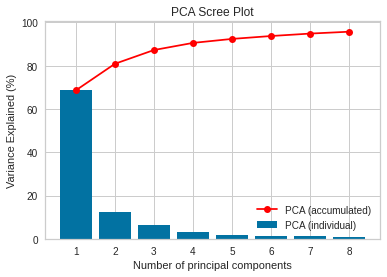

CPU times: user 6.3 s, sys: 2.48 s, total: 8.78 s
Wall time: 1.47 s


In [19]:
%%time
word2vec_lem_pca = hp.reduce_dim(scaler="StandardScaler", data=word2vec_lem, scree=True)

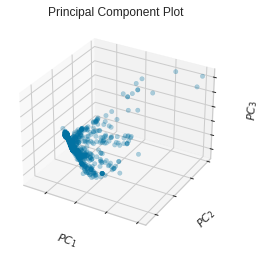

In [62]:
# instantiate PCA from yellowbrick
visualizer_3d_lem = yb_PCA(projection=3, alpha=0.3)
# fit and transform word2vec_lem
visualizer_3d_lem.fit_transform(word2vec_lem)
# show visualization
visualizer_3d_lem.show()
plt.show()

In [63]:
# backup word2vec_lem_pca
np.save('data/pca_word2vec_lem.npy', word2vec_lem_pca)

### Stemming

Original number of features:                    2591
No. of features after dimensionality reduction: 7
Features reduced by:                            99.73%



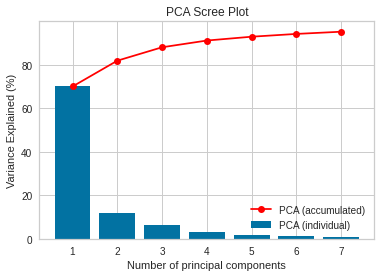

CPU times: user 5.83 s, sys: 3.01 s, total: 8.84 s
Wall time: 1.42 s


In [21]:
%%time
word2vec_stem_pca = hp.reduce_dim(scaler="StandardScaler", data=word2vec_stem, scree=True)

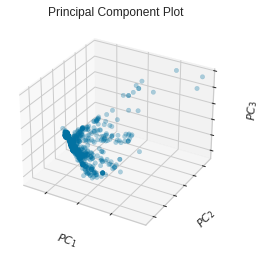

In [65]:
# instantiate PCA from yellowbrick
visualizer_3d_stem = yb_PCA(projection=3, alpha=0.3)
# fit and transform word2vec_stem
visualizer_3d_stem.fit_transform(word2vec_stem)
# show visualization
visualizer_3d_stem.show()
plt.show()

In [66]:
# backup word2vec_stem_pca
np.save('data/pca_word2vec_stem.npy', word2vec_stem_pca)

### Lemmatization & Stemming

Original number of features:                    2593
No. of features after dimensionality reduction: 7
Features reduced by:                            99.73%



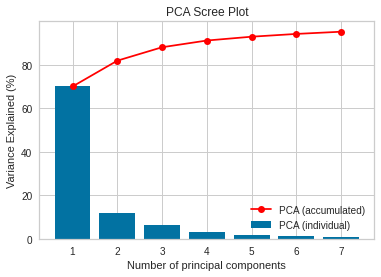

CPU times: user 6.86 s, sys: 4.44 s, total: 11.3 s
Wall time: 1.79 s


In [22]:
%%time
word2vec_lem_stem_pca = hp.reduce_dim(scaler="StandardScaler", data=word2vec_lem_stem, scree=True)

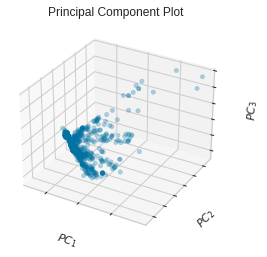

In [68]:
# instantiate PCA from yellowbrick
visualizer_3d_lem_stem = yb_PCA(projection=3, alpha=0.3)
# fit and transform word2vec_stem
visualizer_3d_lem_stem.fit_transform(word2vec_lem_stem)
# show visualization
visualizer_3d_lem_stem.show()
plt.show()

In [69]:
# backup word2vec_stem_pca
np.save('data/pca_word2vec_lem_stem.npy', word2vec_lem_stem_pca)

## Classification Non Supervisée - KMeans

### Lemmatization

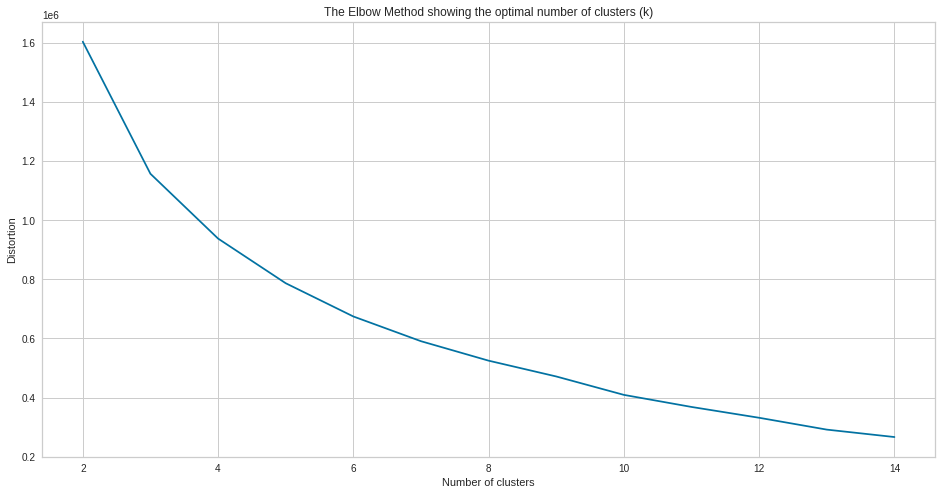

CPU times: user 8.18 s, sys: 1.11 s, total: 9.29 s
Wall time: 2.77 s


In [23]:
%%time
kmeans_lem = hp.find_cluster_numbers(2, 15, word2vec_lem_pca, random_state=1301)

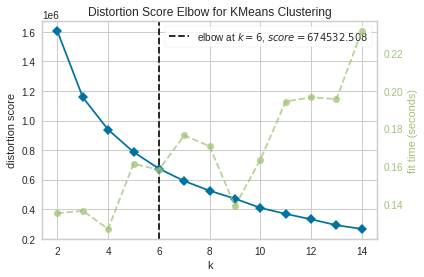

CPU times: user 7.25 s, sys: 960 ms, total: 8.21 s
Wall time: 2.48 s


In [25]:
%%time
hp.plot_elbow_visualizer(2, 15, word2vec_lem_pca, random_state=1301)

### Stemming

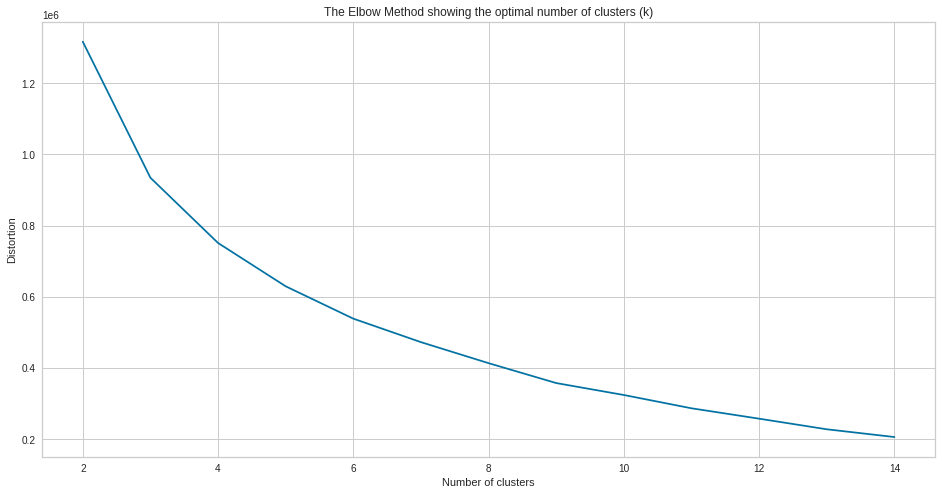

CPU times: user 8.62 s, sys: 1.11 s, total: 9.74 s
Wall time: 2.95 s


In [26]:
%%time
kmeans_stem = hp.find_cluster_numbers(2, 15, word2vec_stem_pca, random_state=1301)

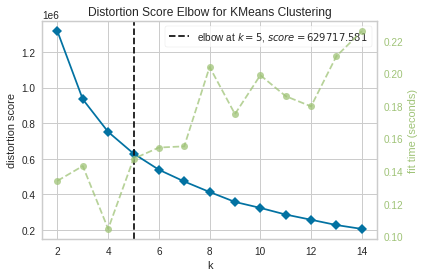

CPU times: user 7.58 s, sys: 975 ms, total: 8.56 s
Wall time: 2.69 s


In [27]:
%%time
hp.plot_elbow_visualizer(2, 15, word2vec_stem_pca, random_state=1301)

### Lemmatization & Stemming

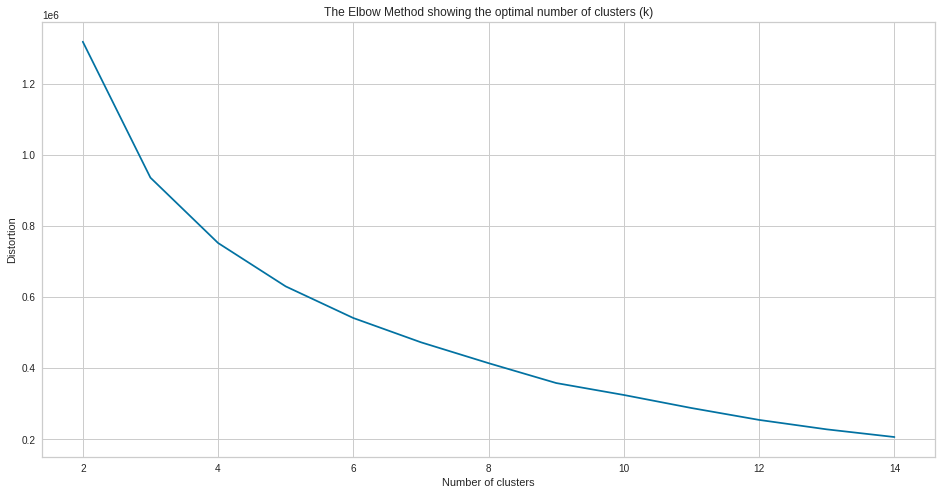

CPU times: user 9.63 s, sys: 1.06 s, total: 10.7 s
Wall time: 3.22 s


In [28]:
%%time
kmeans_lem_stem = hp.find_cluster_numbers(2, 15, word2vec_lem_stem_pca, random_state=1301)

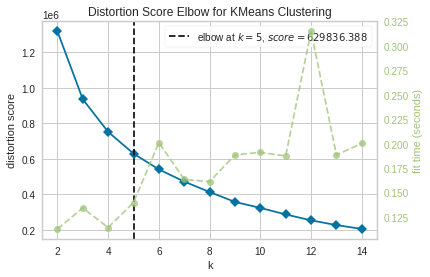

CPU times: user 7.62 s, sys: 916 ms, total: 8.53 s
Wall time: 2.6 s


In [29]:
%%time
hp.plot_elbow_visualizer(2, 15, word2vec_lem_stem_pca, random_state=1301)

**Remarque**<br>
Le meilleur nombre de clusters pour lemmatization, stemming et lemmatization&stemming sont 6, 5 et 5 respectivement.

## Visualisation de Clusters

### Lemmatization

In [31]:
%%time
# generate TSNE embedded space in 2 dimensions
df_tsne_lem = hp.generate_TSNE_dimensions(word2vec_lem_pca)
# add kmeans cluters in the df
df_tsne_lem["clusters_lem_6"] = kmeans_lem[6]
df_tsne_lem["clusters_lem_7"] = kmeans_lem[7]

CPU times: user 57 s, sys: 0 ns, total: 57 s
Wall time: 8.26 s


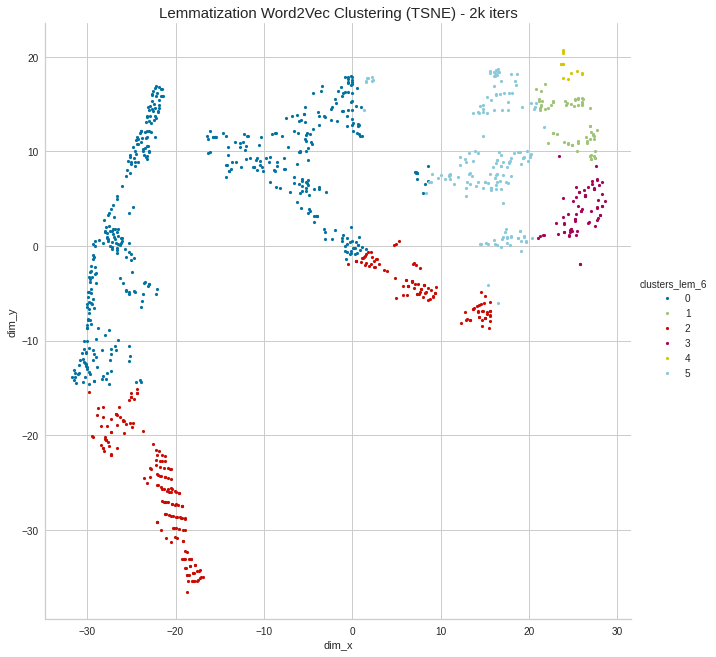

In [67]:
# plot the 6 word2vec clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_lem,
    hue="clusters_lem_6",
    title="Lemmatization Word2Vec Clustering (TSNE) - 2k iters",
    alpha=1,
)

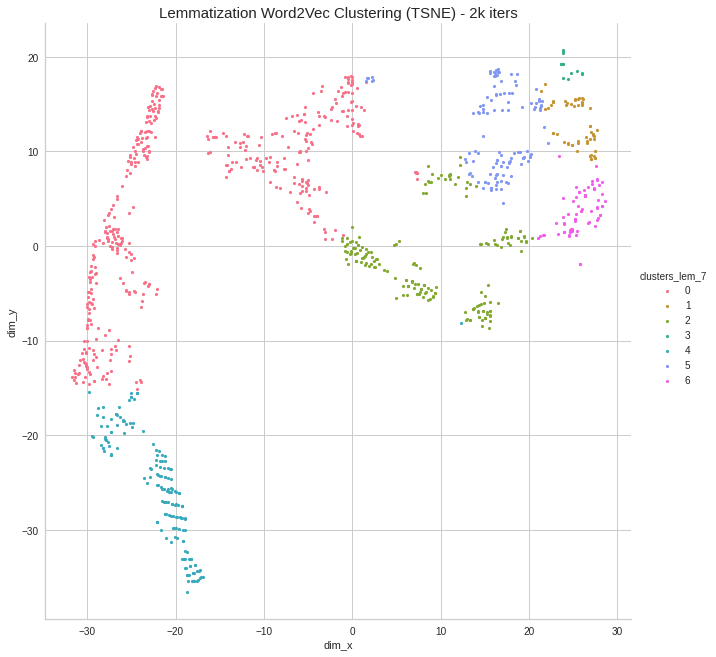

In [66]:
# plot the 7 word2vec clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_lem,
    hue="clusters_lem_7",
    title="Lemmatization Word2Vec Clustering (TSNE) - 2k iters",
    alpha=1,
)

### Stemming

In [35]:
%%time
# generate TSNE embedded space in 2 dimensions
df_tsne_stem = hp.generate_TSNE_dimensions(word2vec_stem_pca)
# add kmeans cluters in the df
df_tsne_stem["clusters_stem_5"] = kmeans_stem[5]
df_tsne_stem["clusters_stem_7"] = kmeans_stem[7]

CPU times: user 47.9 s, sys: 0 ns, total: 47.9 s
Wall time: 6.93 s


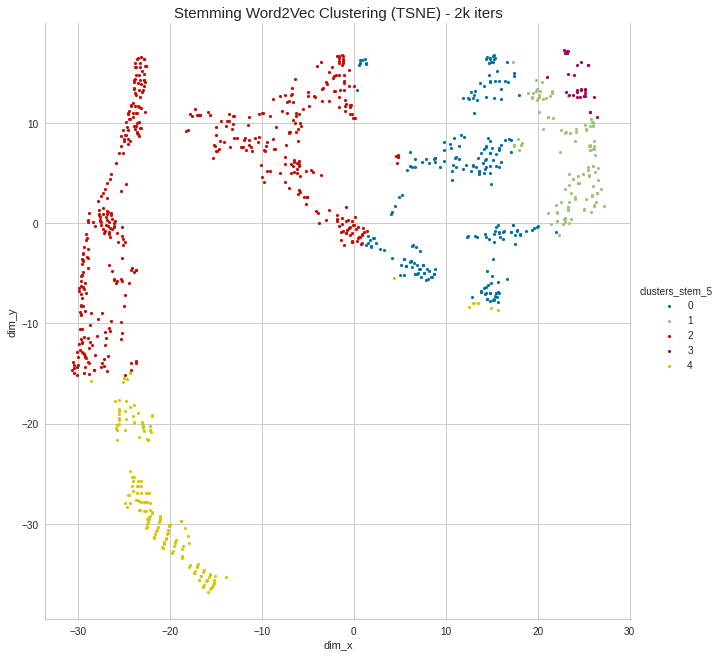

In [65]:
# plot the 5 word2vec clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_stem,
    hue="clusters_stem_5",
    title="Stemming Word2Vec Clustering (TSNE) - 2k iters",
    alpha=1,
)

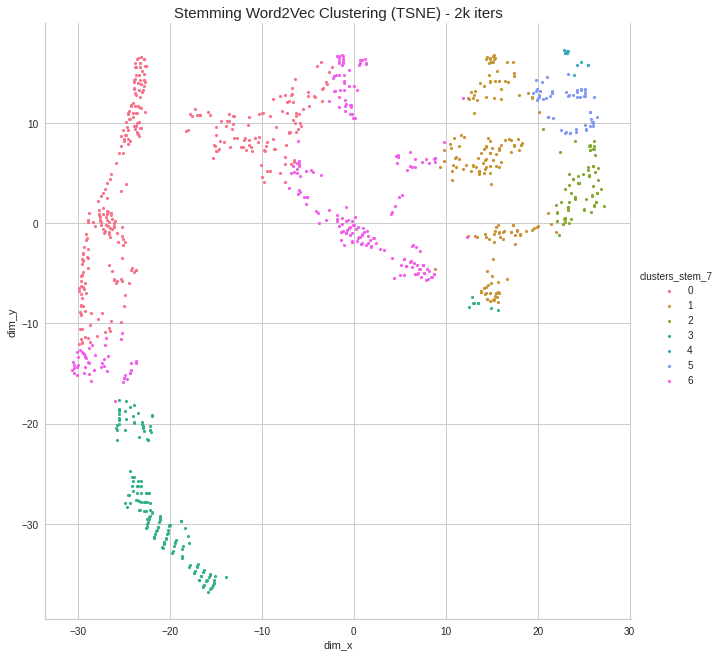

In [64]:
# plot the 7 word2vec clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_stem,
    hue="clusters_stem_7",
    title="Stemming Word2Vec Clustering (TSNE) - 2k iters",
    alpha=1,
)

### Lemmatization & Stemming

In [48]:
%%time
# generate TSNE embedded space in 2 dimensions
df_tsne_lem_stem = hp.generate_TSNE_dimensions(word2vec_lem_stem_pca)
# add kmeans cluters in the df
df_tsne_lem_stem["clusters_lem_stem_5"] = kmeans_lem_stem[5]
df_tsne_lem_stem["clusters_lem_stem_7"] = kmeans_lem_stem[7]

CPU times: user 57.7 s, sys: 113 ms, total: 57.8 s
Wall time: 8.38 s


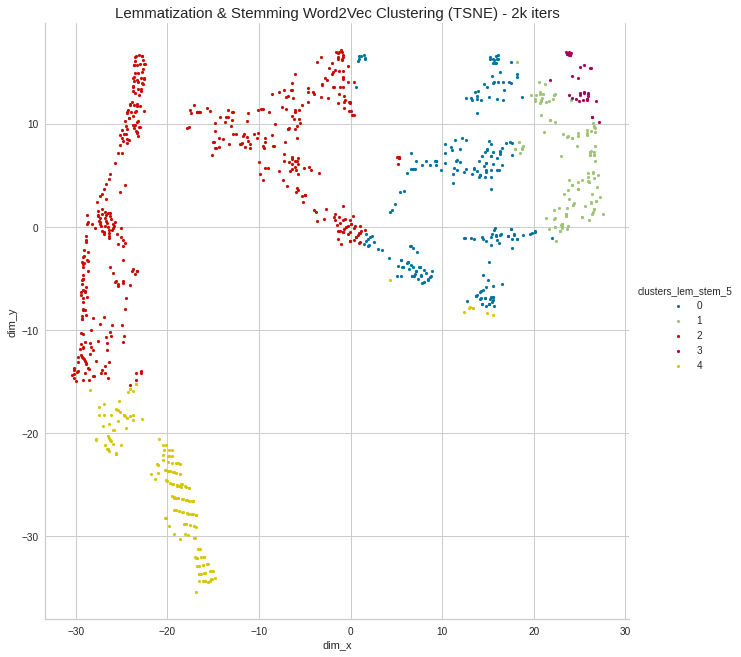

In [62]:
# plot the 5 word2vec clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_lem_stem,
    hue="clusters_lem_stem_5",
    title="Lemmatization & Stemming Word2Vec Clustering (TSNE) - 2k iters",
    alpha=1,
)

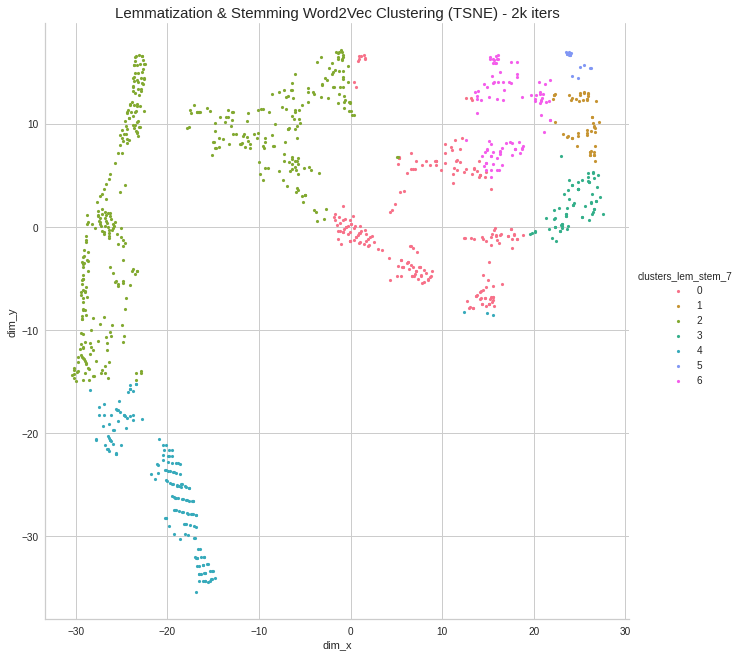

In [61]:
# plot the 7 word2vec clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_lem_stem,
    hue="clusters_lem_stem_7",
    title="Lemmatization & Stemming Word2Vec Clustering (TSNE) - 2k iters",
    alpha=1,
)

## Comparer le Résultat Clustering de Word2Vec avec les Catégories Produits

### Lemmatization

In [76]:
# combine clusters assignment with df
df_clusters_lem = df.cat.copy().to_frame()
df_clusters_lem['clusters_6'] = kmeans_lem[6]
df_clusters_lem['clusters_7'] = kmeans_lem[7]
df_clusters_lem.sample(5)

,cat,clusters_6,clusters_7
354,Computers,2,4
955,Home Decor & Festive Needs,1,5
449,Baby Care,0,0
356,Beauty and Personal Care,2,4
953,Home Furnishing,1,1


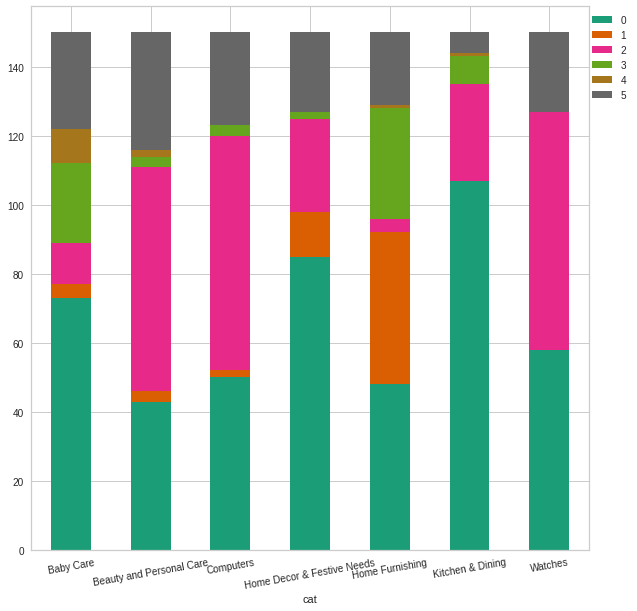

In [77]:
# group clusters_6 by cat
hp.plot_stacked_barchart(df_clusters_lem, "cat", "clusters_6")

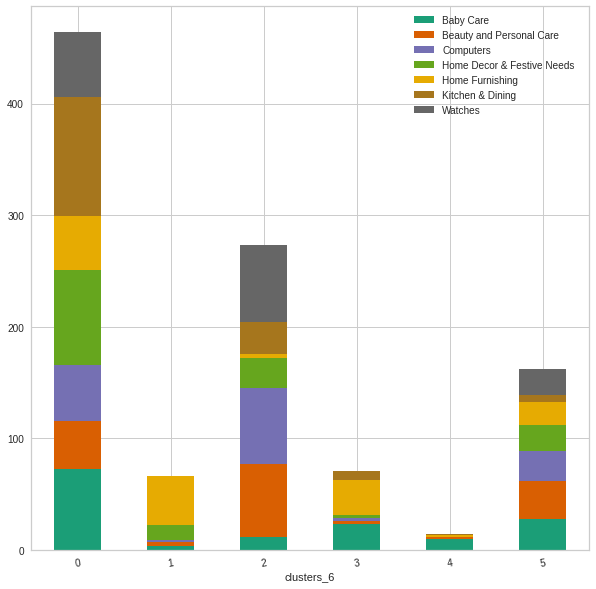

In [78]:
# group cat by clusters_6
hp.plot_stacked_barchart(df_clusters_lem, "clusters_6", "cat")

### Stemming

In [79]:
# combine clusters assignment with df
df_clusters_stem = df.cat.copy().to_frame()
df_clusters_stem['clusters_5'] = kmeans_stem[5]
df_clusters_stem['clusters_7'] = kmeans_stem[7]
df_clusters_stem.sample(5)

,cat,clusters_5,clusters_7
196,Home Decor & Festive Needs,2,0
577,Watches,2,6
841,Computers,0,1
618,Baby Care,0,6
266,Kitchen & Dining,2,0


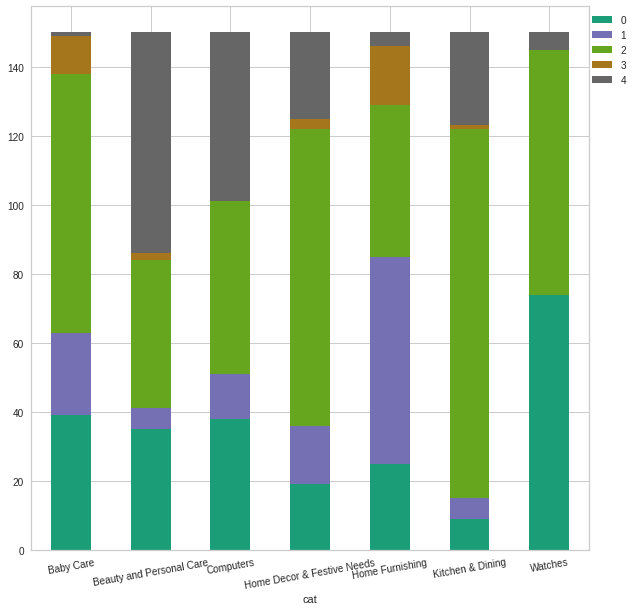

In [80]:
# group clusters_5 by cat
hp.plot_stacked_barchart(df_clusters_stem, "cat", "clusters_5")

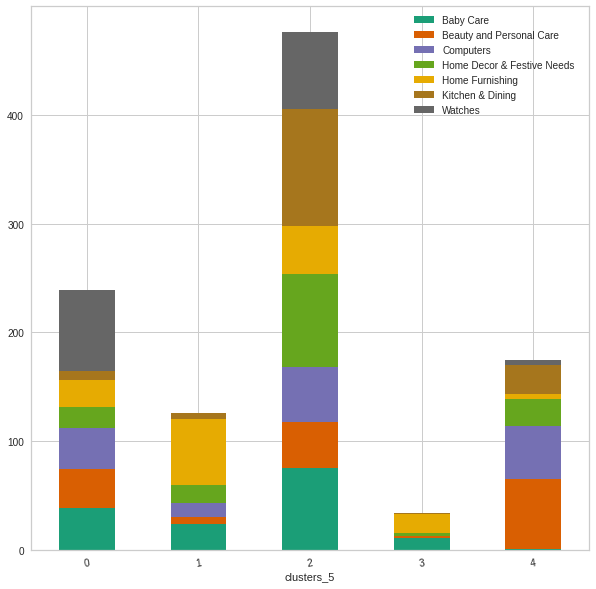

In [81]:
# group cat by clusters_5
hp.plot_stacked_barchart(df_clusters_stem, "clusters_5", "cat")

### Lemmatization & Stemming

In [82]:
# combine clusters assignment with df
df_clusters_lem_stem = df.cat.copy().to_frame()
df_clusters_lem_stem['clusters_5'] = kmeans_lem_stem[5]
df_clusters_lem_stem['clusters_7'] = kmeans_lem_stem[7]
df_clusters_lem_stem.sample(5)

,cat,clusters_5,clusters_7
163,Kitchen & Dining,2,2
185,Kitchen & Dining,2,2
879,Home Furnishing,1,1
868,Home Furnishing,0,6
597,Baby Care,2,2


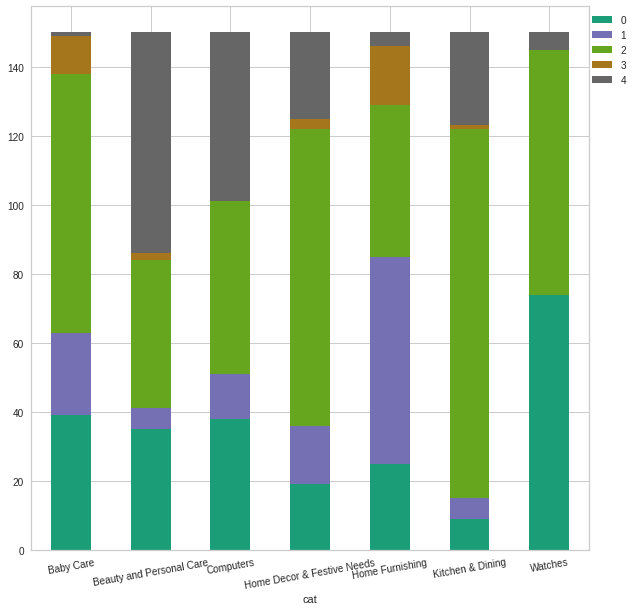

In [83]:
# group clusters_5 by cat
hp.plot_stacked_barchart(df_clusters_lem_stem, "cat", "clusters_5")

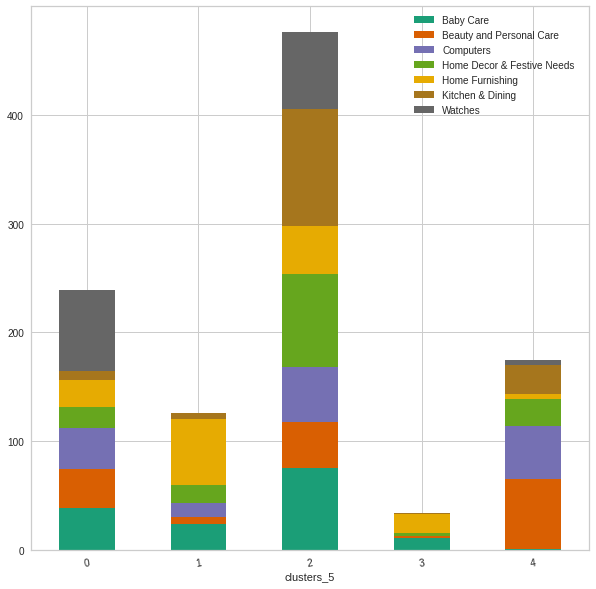

In [84]:
# group cat by clusters_5
hp.plot_stacked_barchart(df_clusters_lem_stem, "clusters_5", "cat")

# Combiner Vecteurs de Texte et d'Image

In [52]:
# import image SIFT descriptors (dimension reduced by PCA)
descriptors_pca = np.load('data/pca_descriptors.npy')

In [53]:
# check dimension of the vectors
print(f"Shape of image SIFT descriptor vector: {descriptors_pca.shape}")
print(f"Shape of word2vec vector: {str(word2vec_lem_stem_pca.shape):>22}")
combined_vec = np.hstack((descriptors_pca, word2vec_lem_pca))
print(f"Shape of the combined vector: {str(combined_vec.shape):>20}")

Shape of image SIFT descriptor vector: (1050, 566)
Shape of word2vec vector:              (1050, 7)
Shape of the combined vector:          (1050, 574)


## Classification Non Supervisée - KMeans

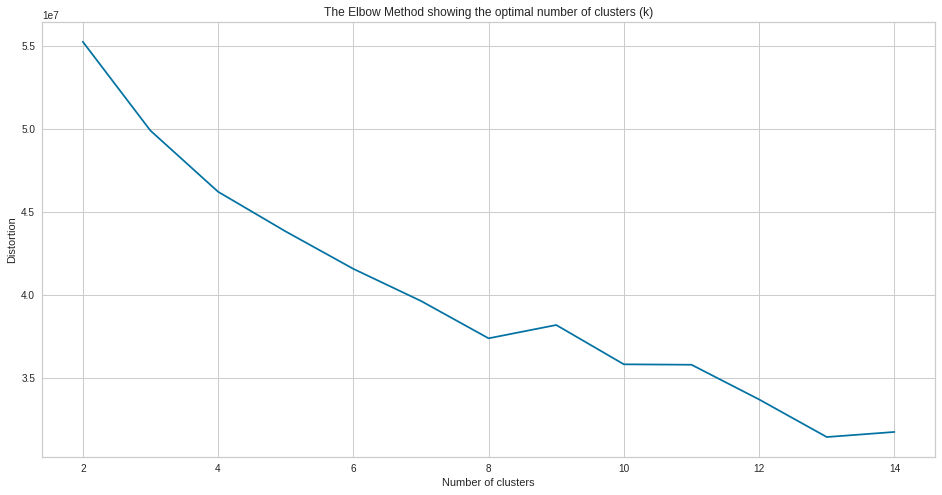

CPU times: user 1min 15s, sys: 50.4 s, total: 2min 5s
Wall time: 20.2 s


In [54]:
%%time
kmeans_combined = hp.find_cluster_numbers(2, 15, combined_vec, random_state=1301)

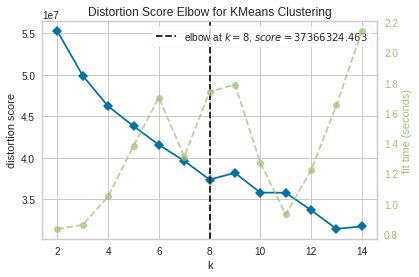

CPU times: user 1min 8s, sys: 46.9 s, total: 1min 55s
Wall time: 18.4 s


In [55]:
%%time
hp.plot_elbow_visualizer(2, 15, combined_vec, random_state=1301)

**Remarque**<br>
Le meilleur nombre de clusters est 8.

## Visualisation de Clusters

In [57]:
%%time
# generate TSNE embedded space in 2 dimensions
df_tsne_combined = hp.generate_TSNE_dimensions(combined_vec)
# add kmeans cluters in the df
df_tsne_combined["clusters_combined_7"] = kmeans_combined[7]
df_tsne_combined["clusters_combined_8"] = kmeans_combined[8]

CPU times: user 1min 19s, sys: 471 ms, total: 1min 19s
Wall time: 11.5 s


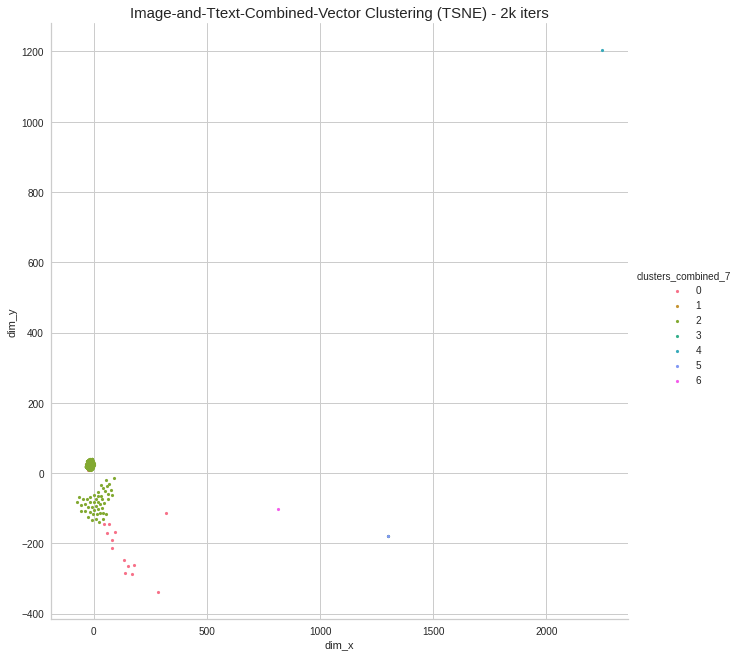

In [58]:
# plot the 7 image-and-text-combined-vector clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_combined,
    hue="clusters_combined_7",
    title="Image-and-Ttext-Combined-Vector Clustering (TSNE) - 2k iters",
    alpha=1,
)

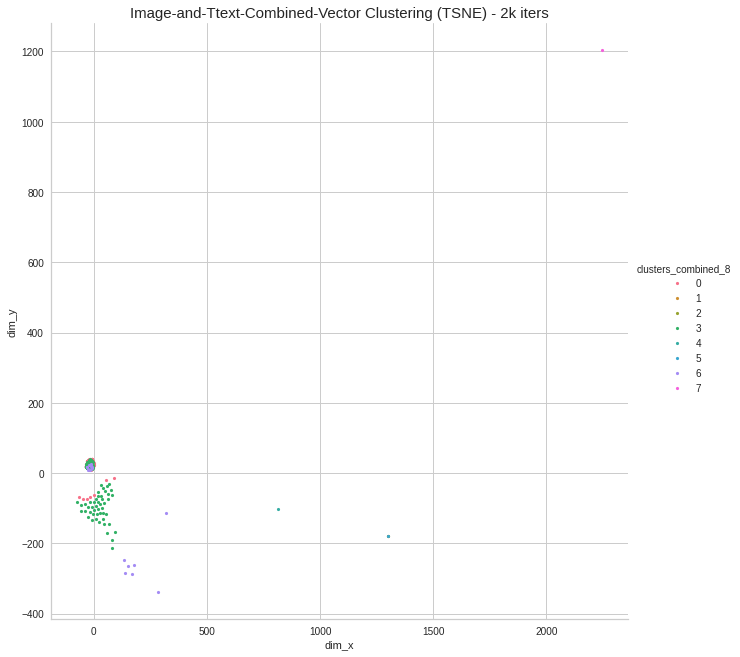

In [59]:
# plot the 58 image-and-text-combined-vector clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_combined,
    hue="clusters_combined_8",
    title="Image-and-Ttext-Combined-Vector Clustering (TSNE) - 2k iters",
    alpha=1,
)

## Comparer le Résultat Clustering des Vecteurs d'Image et de Texte avec les Catégories Produits

In [90]:
# create df for the combined vector data
df_combined = df['cat'].copy()
# combine clusters assignment with df_combined
df_combined = df.copy()
df_combined['clusters_7'] = kmeans_combined[7]
df_combined['clusters_8'] = kmeans_combined[8]
df_combined[['cat', 'clusters_7', 'clusters_8']].sample(5)

,cat,clusters_7,clusters_8
51,Computers,2,0
841,Computers,2,0
434,Computers,2,0
747,Beauty and Personal Care,2,0
337,Beauty and Personal Care,2,0


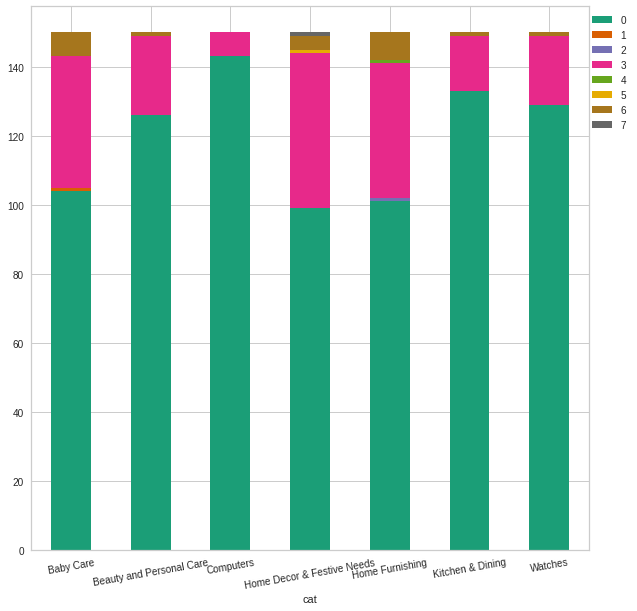

In [91]:
# group clusters_8 by cat
hp.plot_stacked_barchart(df_combined, "cat", "clusters_8")

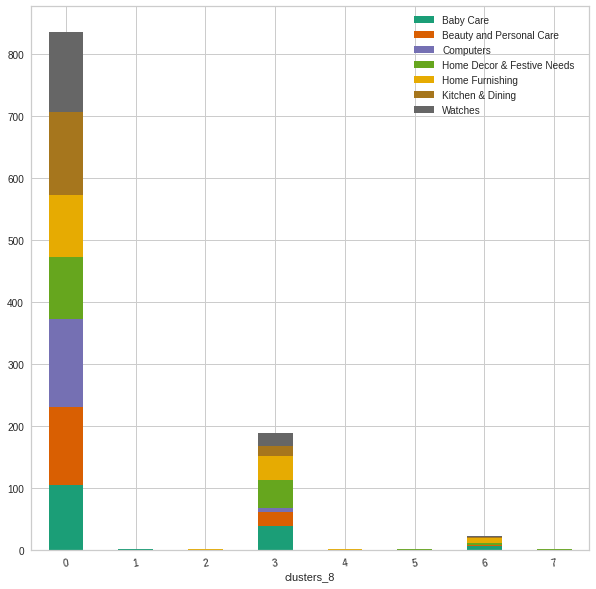

In [92]:
# group cat by clusters_8
hp.plot_stacked_barchart(df_combined, "clusters_8", "cat")

# Topic Modeling

## Lemmatization & Stemming

In [10]:
# create a vocabulary collection for the whole corpus
vocab_dict = Dictionary([tokens for tokens in df.token_lem_stem])
vocab_dict.filter_extremes(no_above=0.7)
# convert each document into a bag of words
bow_corpus = [vocab_dict.doc2bow(tokens) for tokens in df.token_lem_stem]
bow_corpus[0][:5]

[(0, 4), (1, 1), (2, 1), (3, 1), (4, 1)]

In [96]:
%%time
# LDA baseline model
lda_baseline = LdaMulticore(bow_corpus, num_topics=7, id2word=vocab_dict, passes=10, random_state=42, chunksize=500, workers=7)

CPU times: user 2.56 s, sys: 1.99 s, total: 4.55 s
Wall time: 4.58 s


In [22]:
# compute coherence score
coherence_model = CoherenceModel(model=lda_baseline, texts=df.token_lem_stem, dictionary=vocab_dict)
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.5836687659195243


In [100]:
# Compute Perplexity
print(f'Perplexity: ', lda_baseline.log_perplexity(bow_corpus))

Perplexity:  -5.440031404442458


In [15]:
# # topic visualization
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_baseline, bow_corpus, vocab_dict)
# pyLDAvis.display(vis)

In [145]:
%%time
### finetune LDA ###
# declare variable
results = {"topics": [], "alpha": [], "eta": [], "coherence": []}

# set topic numbers
topic_nums = range(4, 9, 1)

# set eta
etas = list(np.arange(0.01, 1, 0.05) * len(vocab_dict.keys()))
etas.append("symmetric")

for topic_num in tqdm(topic_nums, desc="topic bar"):
    # set alpha
    alphas = list(np.arange(0.01, 1, 0.05)*topic_num)
    alphas.append("symmetric")
    alphas.append("asymmetric")
    
    for alpha in tqdm(alphas, desc="alpha bar"):
        for eta in etas:
            lda = LdaMulticore(
                bow_corpus,
                num_topics=topic_num,
                id2word=vocab_dict,
                alpha=alpha,
                eta=eta,
                passes=10,
                random_state=42,
                chunksize=200,
                workers=7,
            )
            # compute coherence score
            coherence_model = CoherenceModel(
                model=lda, texts=df.token_lem_stem, dictionary=vocab_dict
            )
            coherence_score = coherence_model.get_coherence()
            results["topics"].append(topic_num)
            results["alpha"].append(alpha)
            results["eta"].append(eta)
            results["coherence"].append(coherence_score)

results = pd.DataFrame(results)



CPU times: user 1h 4min 23s, sys: 53min 37s, total: 1h 58min
Wall time: 2h 58s


In [148]:
# save LDA grid search results
results.to_csv('data/lda_results', index=False)

In [ ]:
# fetch LDA grid search results
# df_results = pd.read_csv('data/lda_results')

In [19]:
# sort coherence score in descending order
df_results.sort_values(by='coherence', ascending=False).head(10)

,topics,alpha,eta,coherence
52,4,0.44,451.35,0.677503
51,4,0.44,407.1,0.669235
1806,7,symmetric,8.85,0.664352
54,4,0.44,539.8500000000001,0.657874
962,6,0.36000000000000004,761.1000000000001,0.656461
53,4,0.44,495.6,0.653364
525,5,0.8000000000000002,8.85,0.648377
964,6,0.36000000000000004,849.6,0.647571
437,4,symmetric,761.1000000000001,0.646416
436,4,symmetric,716.85,0.646416


In [24]:
%%time
# training LDA model with the best parameters for 4 topics
num_topics=4
lda_best_4 = LdaMulticore(
    bow_corpus,
    num_topics=num_topics,
    id2word=vocab_dict,
    alpha=0.11*num_topics,
    eta=0.51*len(vocab_dict.keys()),
    passes=10,
    random_state=42,
    chunksize=200,
    workers=7,
)

CPU times: user 2.23 s, sys: 1.69 s, total: 3.92 s
Wall time: 3.9 s


In [25]:
# compute coherence score
coherence_model = CoherenceModel(model=lda_best_4, texts=df.token_lem_stem, dictionary=vocab_dict)
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

# Compute Perplexity
print(f'Perplexity: ', lda_best_4.log_perplexity(bow_corpus))

Coherence Score: 0.6775031583531413
Perplexity:  -6.808467640910348


In [40]:
%%time
# training LDA model with the best parameters for 7 topics
num_topics=7
lda_best_7 = LdaMulticore(
    bow_corpus,
    num_topics=num_topics,
    id2word=vocab_dict,
    alpha='symmetric',
    eta=0.01*len(vocab_dict.keys()),
    passes=10,
    random_state=42,
    chunksize=200,
    workers=7,
)

CPU times: user 1.67 s, sys: 1.38 s, total: 3.05 s
Wall time: 3.08 s


In [41]:
# compute coherence score
coherence_model = CoherenceModel(model=lda_best_7, texts=df.token_lem_stem, dictionary=vocab_dict)
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

# Compute Perplexity
print(f'Perplexity: ', lda_best_7.log_perplexity(bow_corpus))

Coherence Score: 0.6643524528976796
Perplexity:  -5.959789393154342


In [26]:
for idx, topic, in lda_best_4.show_topics(num_words=20):
    print(f"Topic {idx} \n {topic}\n")

Topic 0 
 0.003*"product" + 0.002*"free" + 0.002*"buy" + 0.002*"ship" + 0.002*"deliveri" + 0.002*"cash" + 0.002*"genuin" + 0.002*"replac" + 0.002*"day" + 0.002*"guarante" + 0.002*"price" + 0.002*"onlin" + 0.002*"com" + 0.002*"watch" + 0.002*"mug" + 0.002*"analog" + 0.002*"set" + 0.002*"design" + 0.002*"best" + 0.001*"featur"

Topic 1 
 0.001*"mug" + 0.001*"babi" + 0.001*"featur" + 0.001*"design" + 0.001*"specif" + 0.001*"pack" + 0.001*"color" + 0.001*"price" + 0.001*"type" + 0.001*"cotton" + 0.001*"box" + 0.001*"packag" + 0.001*"materi" + 0.001*"general" + 0.001*"print" + 0.001*"sale" + 0.001*"number" + 0.001*"detail" + 0.001*"fabric" + 0.001*"girl"

Topic 2 
 0.001*"babi" + 0.001*"featur" + 0.001*"specif" + 0.001*"pack" + 0.001*"color" + 0.001*"cotton" + 0.001*"type" + 0.001*"general" + 0.001*"box" + 0.001*"packag" + 0.001*"price" + 0.001*"print" + 0.001*"design" + 0.001*"sale" + 0.001*"detail" + 0.001*"number" + 0.001*"girl" + 0.001*"fabric" + 0.001*"materi" + 0.001*"brand"

Topic 3 

In [211]:
for idx, topic, in lda_best_7.show_topics(num_words=20):
    print(f"Topic {idx} \n {topic}\n")

Topic 0 
 0.015*"mug" + 0.006*"bring" + 0.006*"design" + 0.006*"beauti" + 0.005*"gift" + 0.005*"perfect" + 0.005*"coffe" + 0.004*"product" + 0.004*"like" + 0.004*"wide" + 0.003*"distinct" + 0.003*"other" + 0.003*"give" + 0.003*"qualiti" + 0.003*"great" + 0.003*"make" + 0.003*"also" + 0.003*"love" + 0.003*"get" + 0.003*"attract"

Topic 1 
 0.010*"featur" + 0.009*"color" + 0.009*"materi" + 0.008*"box" + 0.008*"model" + 0.007*"type" + 0.007*"price" + 0.007*"number" + 0.007*"product" + 0.007*"packag" + 0.006*"specif" + 0.006*"pack" + 0.006*"inch" + 0.006*"use" + 0.006*"brand" + 0.006*"sale" + 0.006*"warranti" + 0.006*"cover" + 0.006*"general" + 0.005*"key"

Topic 2 
 0.012*"adapt" + 0.011*"laptop" + 0.009*"warranti" + 0.009*"batteri" + 0.008*"replac" + 0.008*"power" + 0.007*"qualiti" + 0.006*"product" + 0.006*"charger" + 0.005*"vgn" + 0.005*"vaio" + 0.005*"usb" + 0.004*"design" + 0.004*"pleas" + 0.004*"includ" + 0.004*"price" + 0.003*"cover" + 0.003*"brand" + 0.003*"also" + 0.003*"carri"



In [212]:
# topic visualization for lda_best_4 model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_best_4, bow_corpus, vocab_dict)
pyLDAvis.display(vis)

In [213]:
# topic visualization for lda_best_7 model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_best_7, bow_corpus, vocab_dict)
pyLDAvis.display(vis)

## Comparer le Résultat de Topic Modeling avec les Catégories Produits

In [44]:
# df_tokens = df.copy()

In [45]:
df_lda = df.copy()

In [49]:
# get best topic of each document for the lda_best_4 model
df_lda['lda_4'] = get_best_topic_per_doc(bow_corpus, lda_best_4)
df_lda[['cat', 'lda_4']].sample(5)

,cat,lda_4
623,Baby Care,1
929,Home Decor & Festive Needs,0
543,Watches,0
572,Watches,0
124,Beauty and Personal Care,0


In [50]:
# get best topic of each document for the lda_best_7 model
df_lda['lda_7'] = get_best_topic_per_doc(bow_corpus, lda_best_7)
df_lda[['cat', 'lda_4', 'lda_7']].sample(5)

,cat,lda_4,lda_7
32,Watches,0,3
751,Home Furnishing,0,3
137,Kitchen & Dining,0,3
878,Home Furnishing,0,1
866,Beauty and Personal Care,1,4


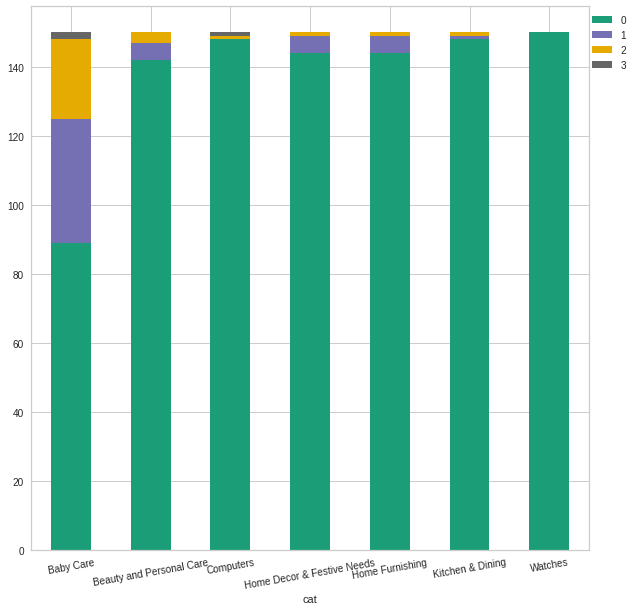

In [53]:
# group topics predicted by lda_4 model by cat
hp.plot_stacked_barchart(df_lda, "cat", "lda_4")

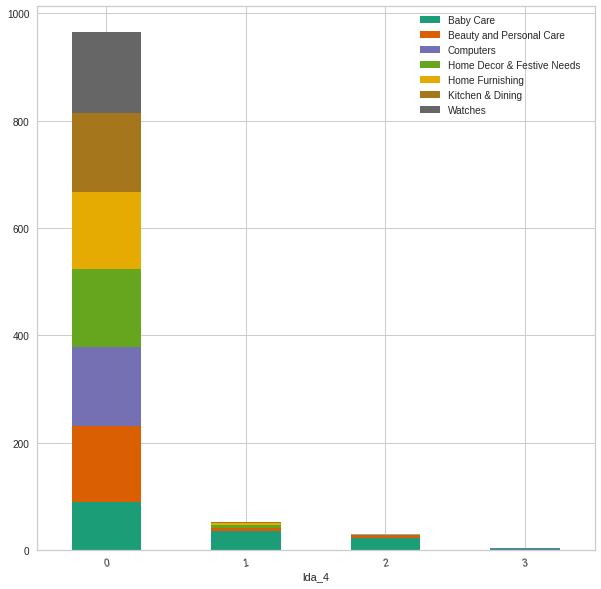

In [54]:
# group cat by cat topics predicted by lda_4 model
hp.plot_stacked_barchart(df_lda, "lda_4", "cat")

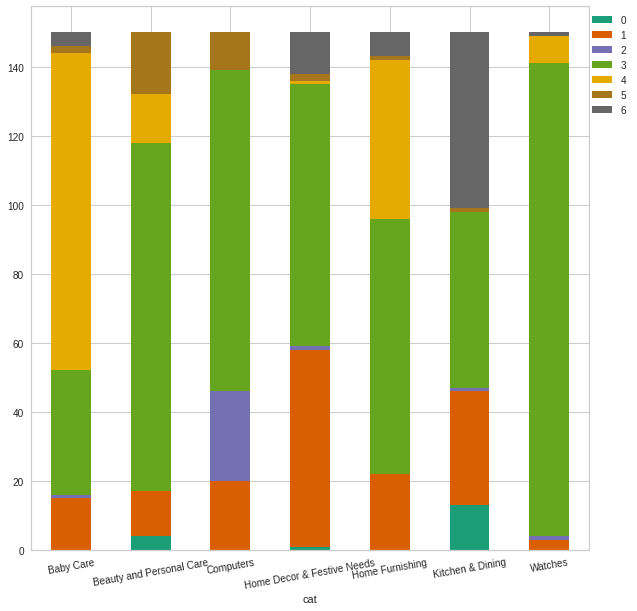

In [56]:
# # group topics predicted by lda_7 model by cat
hp.plot_stacked_barchart(df_lda, "cat", "lda_7")

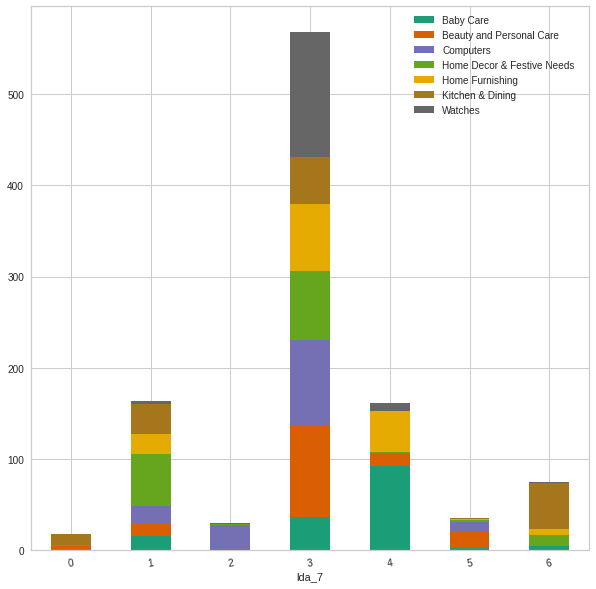

In [57]:
# group cat by cat topics predicted by lda_7 model
hp.plot_stacked_barchart(df_lda, "lda_7", "cat")

# TF-IDF

## Lemmatization & Stemming

In [179]:
def identity_tokenizer(text):
    """ Return the tokenized text as it is
    """
    return text

In [186]:
# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
# tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words=stop_words, lowercase=False)

# get English stopwords
stop_words = set(stopwords.words("english"))
stop_words.add("flipkart")
stop_words.add("rockmantra")

# fit and transform tokens and get the TFIDF vectors in a matric format
play = [entry for _, entry in df.token_lem_stem.iteritems()]
tfidf_wrd_mtrx_scipy = tfidf.fit_transform(raw_documents=play)
tfidf_wrd_mtrx = tfidf_wrd_mtrx_scipy.toarray()
tfidf_wrd_mtrx.shape

(1050, 3534)

In [187]:
type(tfidf_wrd_mtrx)

numpy.ndarray

In [178]:
# selected terms from the raw documents
print(*tfidf.get_feature_names())

. aaa aapno aari abil abl abod abras abroad absolut absorb abstract abstrct accent access accessori accid accident accommod accomplish accord acer ach acid acn across acryl act activ actual ad adapt adaptor add addict addit adhes adi adida adjust admir ador adorn adsl advanc advic advis aero affect afford afternoon agarwood age ageless agrasen agre aid air airport airtex airtight ajmal alarm alcohol aleo alfajr aliv alli allin allov allow alloy alluminium allur almond almost alo aloevera along alpha alphabet alram also alter altern although altimet altitud aluminium aluminum alway amaz ambienc america amit ammonia amnesia among amongst amount amp amplifi analog analogu analyz ancestr ancient andr andriod android angel angelica angri anim anis anjeer anna anniversari annoy anod anodis anoth ant antenna anthelio anthil anti antibacteri antimicrobi antiqu antra anymor anyon anyth anytim anywher apart app appar apparel appeal appear appl appli applic appliqu appreci approach approx apron a

manufactur manuka mapl marbl marco margin mari market marketplac maroon marvel masala maserati mask massag master mat match materi mathemat matt mattegel matter mattress max maxim maxima maximum may mayb mbps mcb mdf mdh meal mean meant meat mechan media mediam medic mediterranean medium mee meenakari meet mega megnet melang member memo memori men mental mention merri mesh messag metal method metr mfan mhz micro microb microfibr microusb microwav middl might mighti mild milion mill milton mind miner mini minim minimum mink minor mint minut miracl mirror mishandl miss mission miter mix mixfruit mmull mnbt mnts mobil mock mocktail mode model modem modern modernist modish modul moist moistur mom moment money monitor monk mono monster month mood moon moreov moriya morn mosaic moshai mosquito mossiac mother motif motiv mount mountabl mous mousepad mouth mov move movement movi mrn mrsa mshoppe mtg much mud mudra mug mukut multi multicolor multicolour multifunct multimedia multipl multipurpos

 vista visual vital vitamin vivid vivifi vizion vlcc voic vol volateg volt voltag volum waist waistband wait waiter walk wall wallet wallpap wallsk wallskart wand want waranti wardrob ware warm warmer warmth warn warranti warrenti wash washabl watch water watercolor waterproof watt wave waveform wax way wealth wear web websit wed week weigh weight weightless welcom well west western wet wglass wheel wher wherea wherev whether whiski white whiteherb whole wide wider width widw wild wind window windsor wine winger wink winner winter wipe wire wireless wisdom wish within without withstand wma wok woman women wonder wood wooden woodi woodino wool word work workmanship workstat world worn worri worshipp would woven wow wowan wrap wrapper wring wrinkl wrist write wrought xemex xyz yardley yarn year yellow yes yet yiboo yield york young youth yr yuva yves zero zikrak zinc zip zipexterior zipper zone zoom zora


## Reduction de Dimension

Original number of features:                    3534
No. of features after dimensionality reduction: 563
Features reduced by:                            84.07%



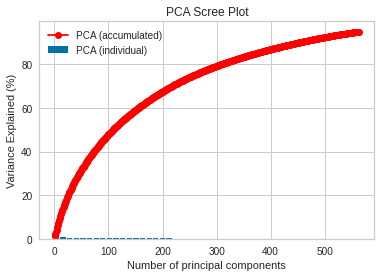

CPU times: user 9.7 s, sys: 4.66 s, total: 14.4 s
Wall time: 3.44 s


In [188]:
%%time
tfidf_wrd_mtrx_pca = hp.reduce_dim(scaler="StandardScaler", data=tfidf_wrd_mtrx, scree=True)

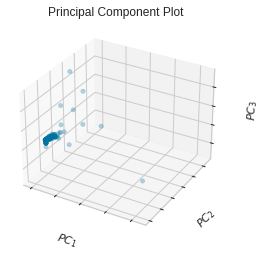

In [189]:
# instantiate PCA from yellowbrick
visualizer_3d_lem_stem = yb_PCA(projection=3, alpha=0.3)
# fit and transform word2vec_stem
visualizer_3d_lem_stem.fit_transform(tfidf_wrd_mtrx)
# show visualization
visualizer_3d_lem_stem.show()
plt.show()

## Classification Non Supervisée - KMeans

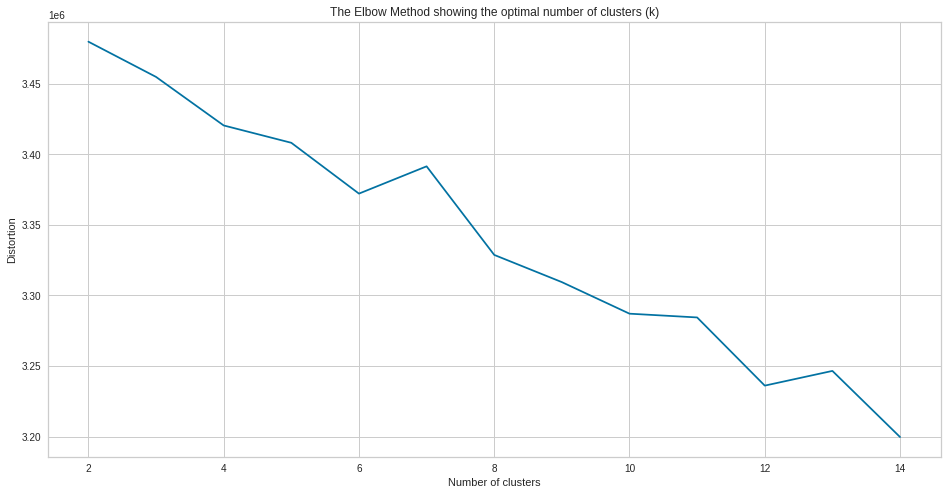

CPU times: user 34.6 s, sys: 29.1 s, total: 1min 3s
Wall time: 9.45 s


In [190]:
%%time
kmeans_tfidf = hp.find_cluster_numbers(2, 15, tfidf_wrd_mtrx_pca, random_state=1301)

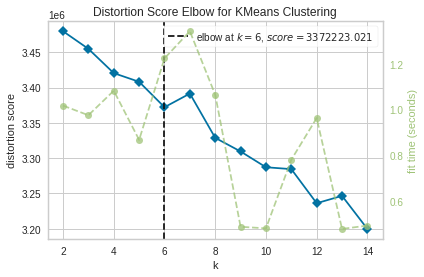

CPU times: user 44.8 s, sys: 33.6 s, total: 1min 18s
Wall time: 11.8 s


In [191]:
%%time
hp.plot_elbow_visualizer(2, 15, tfidf_wrd_mtrx_pca, random_state=1301)

**Remarque**<br>
Le meilleur nombre de clusters pour TFIDF est 6.

## Visualisation de Clusters

In [192]:
%%time
# generate TSNE embedded space in 2 dimensions
df_tsne_tfidf = hp.generate_TSNE_dimensions(tfidf_wrd_mtrx_pca)
# add kmeans cluters in the df
df_tsne_tfidf["clusters_tfidf_6"] = kmeans_tfidf[6]
df_tsne_tfidf["clusters_tfidf_7"] = kmeans_tfidf[7]

CPU times: user 1min 16s, sys: 412 ms, total: 1min 16s
Wall time: 11.1 s


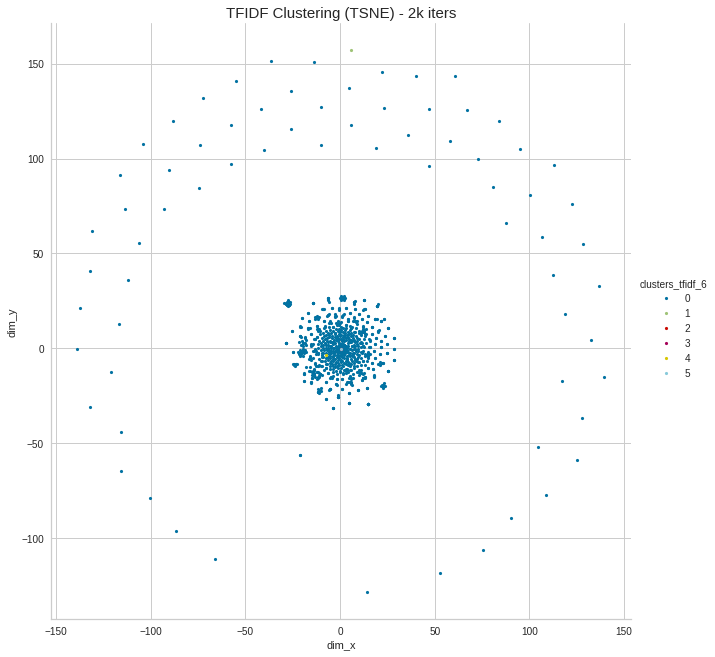

In [210]:
# plot the 6 TFIDF clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_tfidf,
    hue="clusters_tfidf_6",
    title="TFIDF Clustering (TSNE) - 2k iters",
    alpha=1,
)

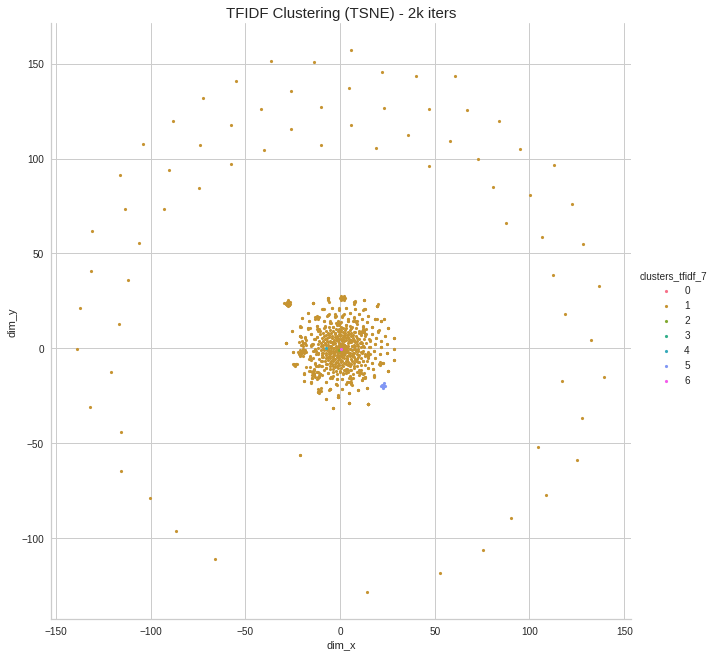

In [209]:
# plot the 7 TFIDF clusters
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne_tfidf,
    hue="clusters_tfidf_7",
    title="TFIDF Clustering (TSNE) - 2k iters",
    alpha=1,
)

## Comparer le Résultat Clustering de Word2Vec avec les Catégories Produits

In [211]:
# combine clusters assignment with df
df_clusters_tfidf = df.cat.copy().to_frame()
df_clusters_tfidf['clusters_6'] = kmeans_tfidf[6]
df_clusters_tfidf['clusters_7'] = kmeans_tfidf[7]
df_clusters_tfidf.sample(5)

,cat,clusters_6,clusters_7
472,Kitchen & Dining,0,1
839,Computers,0,1
339,Computers,0,1
968,Baby Care,0,1
530,Watches,0,1


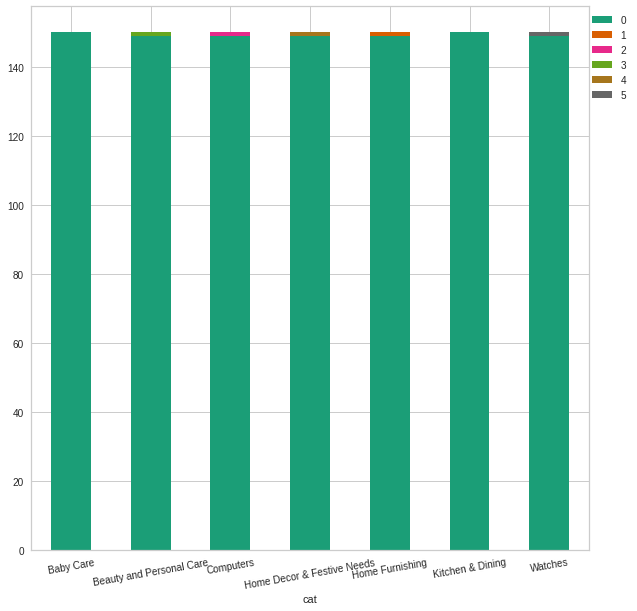

In [212]:
# group clusters_6 by cat
hp.plot_stacked_barchart(df_clusters_tfidf, "cat", "clusters_6")

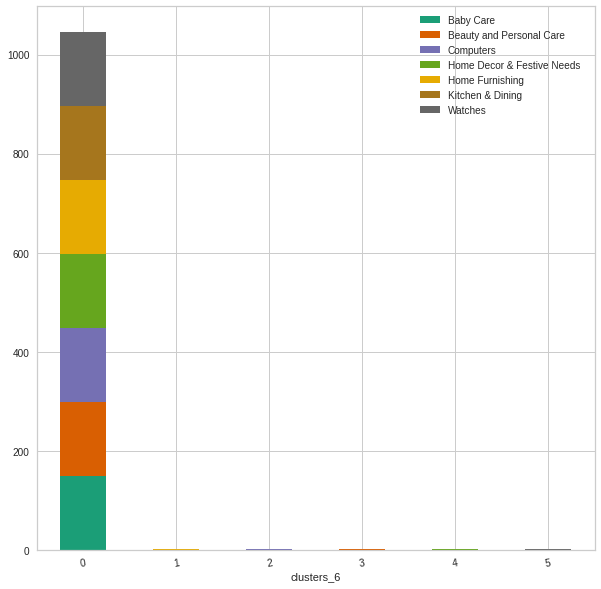

In [213]:
# group cat by clusters_6
hp.plot_stacked_barchart(df_clusters_tfidf, "clusters_6", "cat")

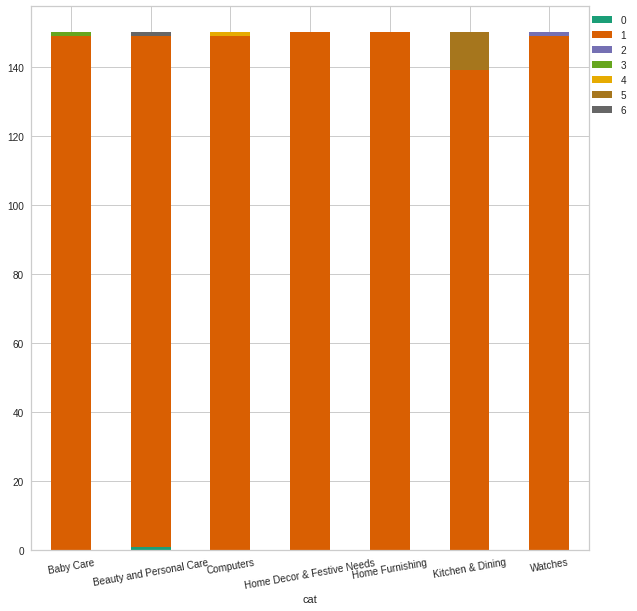

In [214]:
# group clusters_7 by cat
hp.plot_stacked_barchart(df_clusters_tfidf, "cat", "clusters_7")

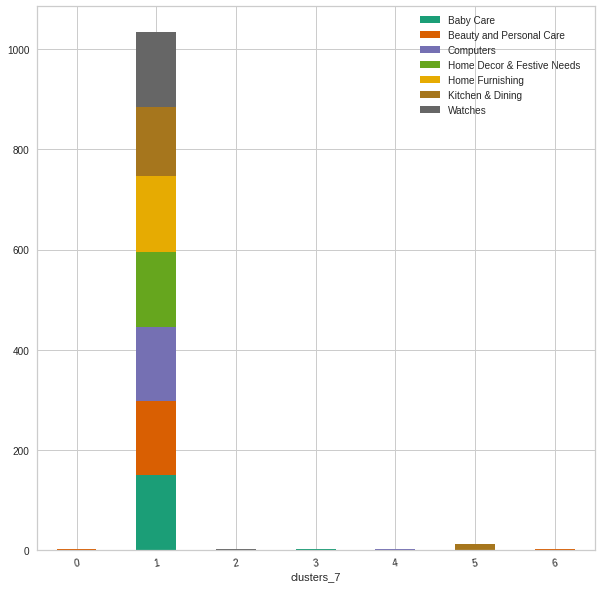

In [215]:
# group cat by clusters_7
hp.plot_stacked_barchart(df_clusters_tfidf, "clusters_7", "cat")

# END